In [1]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt

In [2]:
df = pd.read_csv('upi_transactions_2024.csv')

In [3]:
# Basic checks
print("Shape:", df.shape)
print("\nData Types:\n", df.dtypes)
print("\nMissing Values:\n", df.isnull().sum())
print("\nDuplicate Rows:", df.duplicated().sum())

# Preview data
df.head()

Shape: (250000, 17)

Data Types:
 transaction id        object
timestamp             object
transaction type      object
merchant_category     object
amount_inr             int64
transaction_status    object
sender_age_group      object
receiver_age_group    object
sender_state          object
sender_bank           object
receiver_bank         object
device_type           object
network_type          object
fraud_flag             int64
hour_of_day            int64
day_of_week           object
is_weekend             int64
dtype: object

Missing Values:
 transaction id        0
timestamp             0
transaction type      0
merchant_category     0
amount_inr            0
transaction_status    0
sender_age_group      0
receiver_age_group    0
sender_state          0
sender_bank           0
receiver_bank         0
device_type           0
network_type          0
fraud_flag            0
hour_of_day           0
day_of_week           0
is_weekend            0
dtype: int64

Duplicate Rows: 0


,transaction id,timestamp,transaction type,merchant_category,amount_inr,transaction_status,sender_age_group,receiver_age_group,sender_state,sender_bank,receiver_bank,device_type,network_type,fraud_flag,hour_of_day,day_of_week,is_weekend
0,TXN0000000001,08-10-2024 15:17,P2P,Entertainment,868,SUCCESS,26-35,18-25,Delhi,Axis,SBI,Android,4G,0,15,Tuesday,0
1,TXN0000000002,11-04-2024 06:56,P2M,Grocery,1011,SUCCESS,26-35,26-35,Uttar Pradesh,ICICI,Axis,iOS,4G,0,6,Thursday,0
2,TXN0000000003,02-04-2024 13:27,P2P,Grocery,477,SUCCESS,26-35,36-45,Karnataka,Yes Bank,PNB,Android,4G,0,13,Tuesday,0
3,TXN0000000004,07-01-2024 10:09,P2P,Fuel,2784,SUCCESS,26-35,26-35,Delhi,ICICI,PNB,Android,5G,0,10,Sunday,1
4,TXN0000000005,23-01-2024 19:04,P2P,Shopping,990,SUCCESS,26-35,18-25,Delhi,Axis,Yes Bank,iOS,WiFi,0,19,Tuesday,0


# Exploratory Data Analysis

## 1: Transaction Amount Distribution

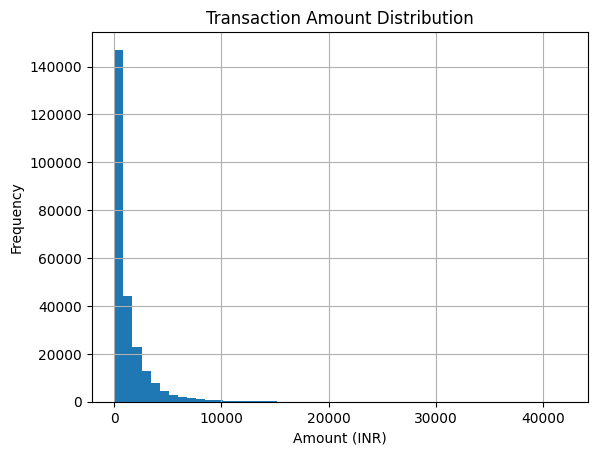

In [4]:


plt.figure()
df['amount_inr'].hist(bins=50)
plt.title("Transaction Amount Distribution")
plt.xlabel("Amount (INR)")
plt.ylabel("Frequency")
plt.show()


## 2: Transaction Status Distribution


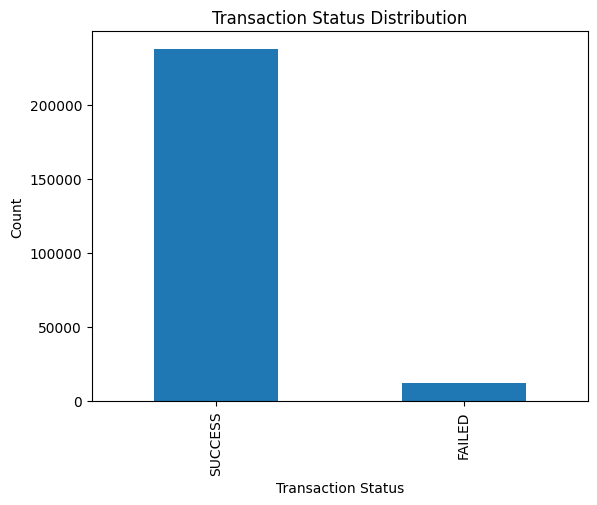

In [5]:
plt.figure()
df['transaction_status'].value_counts().plot(kind='bar')
plt.title("Transaction Status Distribution")
plt.xlabel("Transaction Status")
plt.ylabel("Count")
plt.show()


## 3: Transactions by Day of Week

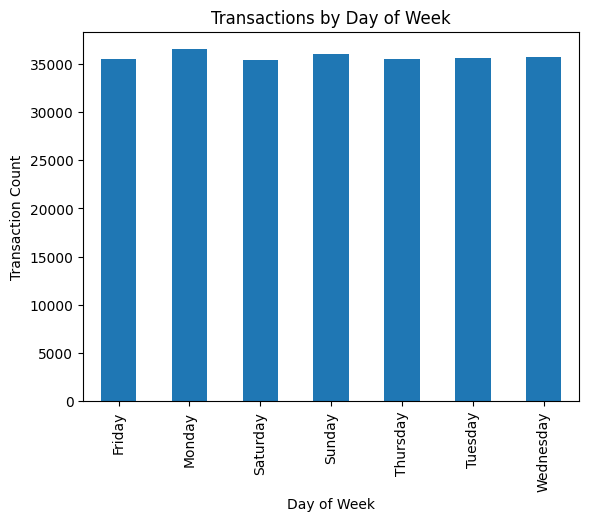

In [6]:
plt.figure()
df['day_of_week'].value_counts().sort_index().plot(kind='bar')
plt.title("Transactions by Day of Week")
plt.xlabel("Day of Week")
plt.ylabel("Transaction Count")
plt.show()


## 4: Transaction Amount vs Status

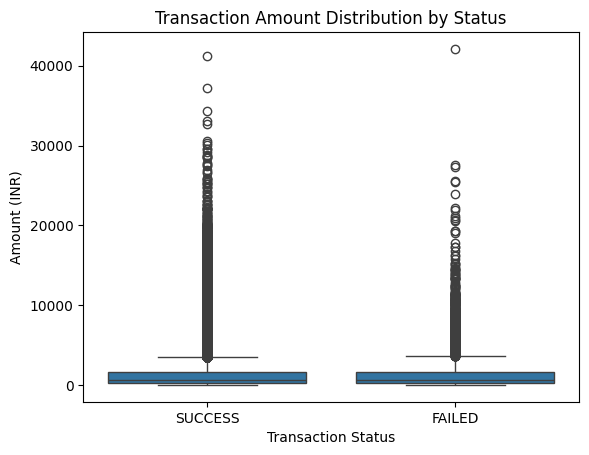

In [7]:
plt.figure()
sns.boxplot(
    data=df,
    x="transaction_status",
    y="amount_inr"
)
plt.title("Transaction Amount Distribution by Status")
plt.xlabel("Transaction Status")
plt.ylabel("Amount (INR)")
plt.show()

## 5: Success Rate by Network Type

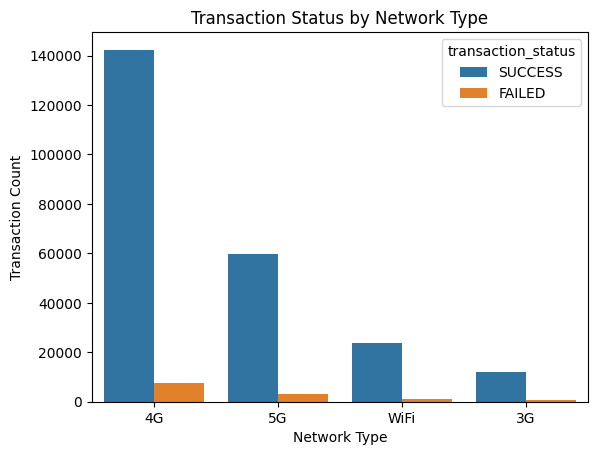

In [8]:
plt.figure()
sns.countplot(
    data=df,
    x="network_type",
    hue="transaction_status"
)
plt.title("Transaction Status by Network Type")
plt.xlabel("Network Type")
plt.ylabel("Transaction Count")
plt.show()

# Machine Learning 

In [9]:
# Create target variable
df['txn_failed'] = df['transaction_status'].map({
    'SUCCESS': 0,
    'FAILED': 1
})

# Verify encoding
df[['transaction_status', 'txn_failed']].head()


,transaction_status,txn_failed
0,SUCCESS,0
1,SUCCESS,0
2,SUCCESS,0
3,SUCCESS,0
4,SUCCESS,0


In [10]:
# Check class balance
df['txn_failed'].value_counts(normalize=True)


txn_failed
0    0.950496
1    0.049504
Name: proportion, dtype: float64

In [11]:
# Select features for ML
feature_cols = [
    'amount_inr',
    'sender_age_group',
    'receiver_age_group',
    'sender_state',
    'sender_bank',
    'receiver_bank',
    'device_type',
    'network_type',
    'hour_of_day',
    'day_of_week',
    'is_weekend'
]

X = df[feature_cols]
y = df['txn_failed']

X.head()


,amount_inr,sender_age_group,receiver_age_group,sender_state,sender_bank,receiver_bank,device_type,network_type,hour_of_day,day_of_week,is_weekend
0,868,26-35,18-25,Delhi,Axis,SBI,Android,4G,15,Tuesday,0
1,1011,26-35,26-35,Uttar Pradesh,ICICI,Axis,iOS,4G,6,Thursday,0
2,477,26-35,36-45,Karnataka,Yes Bank,PNB,Android,4G,13,Tuesday,0
3,2784,26-35,26-35,Delhi,ICICI,PNB,Android,5G,10,Sunday,1
4,990,26-35,18-25,Delhi,Axis,Yes Bank,iOS,WiFi,19,Tuesday,0


In [12]:
# Identify column types
# Correct numerical features
num_features = [
    'amount_inr',
    'hour_of_day',
    'is_weekend'
]

# Correct categorical features
cat_features = [
    'sender_age_group',
    'receiver_age_group',
    'sender_state',
    'sender_bank',
    'receiver_bank',
    'device_type',
    'network_type',
    'day_of_week'
]


In [13]:
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer


In [14]:
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer

preprocessor = ColumnTransformer(
    transformers=[
        ('num', 'passthrough', num_features),
        ('cat', OneHotEncoder(handle_unknown='ignore'), cat_features)
    ]
)



In [15]:
X_transformed = preprocessor.fit_transform(X)

X_transformed.shape


(250000, 53)

In [16]:
from sklearn.model_selection import train_test_split

# Split data
X_train, X_test, y_train, y_test = train_test_split(
    X_transformed,
    y,
    test_size=0.2,
    random_state=42,
    stratify=y
)

X_train.shape, X_test.shape


((200000, 53), (50000, 53))

In [17]:
from sklearn.linear_model import LogisticRegression

# Initialize model
log_model = LogisticRegression(max_iter=1000)

# Train model
log_model.fit(X_train, y_train)


LogisticRegression(max_iter=1000)

In [18]:
# Predictions
y_pred = log_model.predict(X_test)
y_pred_prob = log_model.predict_proba(X_test)[:, 1]


In [19]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, roc_auc_score

print("Accuracy:", accuracy_score(y_test, y_pred))
print("Precision:", precision_score(y_test, y_pred))
print("Recall:", recall_score(y_test, y_pred))
print("ROC-AUC:", roc_auc_score(y_test, y_pred_prob))


Accuracy: 0.9505
Precision: 0.0
Recall: 0.0
ROC-AUC: 0.503361169825557


C:\Users\khush\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [20]:
from sklearn.ensemble import RandomForestClassifier

rf_model = RandomForestClassifier(
    n_estimators=200,
    random_state=42,
    class_weight='balanced',
    n_jobs=-1
)

rf_model.fit(X_train, y_train)


RandomForestClassifier(class_weight='balanced', n_estimators=200, n_jobs=-1,
                       random_state=42)

In [21]:
y_pred_rf = rf_model.predict(X_test)
y_pred_prob_rf = rf_model.predict_proba(X_test)[:, 1]


In [22]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, roc_auc_score

print("Accuracy:", accuracy_score(y_test, y_pred_rf))
print("Precision:", precision_score(y_test, y_pred_rf))
print("Recall:", recall_score(y_test, y_pred_rf))
print("ROC-AUC:", roc_auc_score(y_test, y_pred_prob_rf))


Accuracy: 0.95024
Precision: 0.0
Recall: 0.0
ROC-AUC: 0.49440301808192394


In [23]:
from sklearn.metrics import confusion_matrix

confusion_matrix(y_test, y_pred_rf)


array([[47512,    13],
       [ 2475,     0]], dtype=int64)

In [24]:
ml_features = [
    "amount_inr",
    "hour_of_day",
    "day_of_week"
]

X = df[ml_features].dropna()



In [25]:
day_mapping = {
    "Monday": 0,
    "Tuesday": 1,
    "Wednesday": 2,
    "Thursday": 3,
    "Friday": 4,
    "Saturday": 5,
    "Sunday": 6
}

df["day_of_week"] = df["day_of_week"].map(day_mapping)


In [26]:
import pandas as pd
import numpy as np
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import IsolationForest


In [27]:
day_mapping = {
    "Monday": 0,
    "Tuesday": 1,
    "Wednesday": 2,
    "Thursday": 3,
    "Friday": 4,
    "Saturday": 5,
    "Sunday": 6
}

df["day_of_week"] = df["day_of_week"].map(day_mapping)


In [28]:
X = df[["amount_inr", "hour_of_day", "day_of_week"]].copy()
X = X.apply(pd.to_numeric, errors="coerce").dropna()


In [40]:
pipeline = Pipeline(steps=[
    ("scaler", StandardScaler()),
    ("model", IsolationForest(
        n_estimators=150,
        contamination=0.01,
        random_state=42
    ))
])


In [42]:
pipeline.fit(X)


Pipeline(steps=[('scaler', StandardScaler()),
                ('model',
                 IsolationForest(contamination=0.01, n_estimators=150,
                                 random_state=42))])

In [43]:
X = df[["amount_inr", "hour_of_day", "day_of_week"]].copy()
X = X.apply(pd.to_numeric, errors="coerce")
X = X.dropna()


In [44]:
df["anomaly_flag"] = pipeline.predict(X)


In [45]:
df["risk_flag"] = df["anomaly_flag"].map({
    -1: "High Risk",
     1: "Normal"
})


In [46]:
df["anomaly_score"] = pipeline.decision_function(X)


In [47]:
df[["amount_inr", "hour_of_day", "day_of_week", "risk_flag", "anomaly_score"]].head()


,amount_inr,hour_of_day,day_of_week,risk_flag,anomaly_score
0,868,15,1,Normal,0.217141
1,1011,6,3,Normal,0.171241
2,477,13,1,Normal,0.235779
3,2784,10,6,Normal,0.128860
4,990,19,1,Normal,0.222314


In [48]:
# ================================
# STEP: MACHINE LEARNING (Anomaly Detection)
# Goal: Create ML output usable in Jupyter + Power BI
# Model: Isolation Forest (Unsupervised)
# ================================

import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import IsolationForest
from sklearn.pipeline import Pipeline

# ----------------
# 1. Load data
# ----------------
df = pd.read_csv("upi_transactions_2024.csv")

# ----------------
# 2. Data Validation & Cleaning (CRITICAL)
# ----------------

# Ensure numeric columns
df["amount_inr"] = pd.to_numeric(df["amount_inr"], errors="coerce")
df["hour_of_day"] = pd.to_numeric(df["hour_of_day"], errors="coerce")

# Fix day_of_week (string → numeric)
day_mapping = {
    "Monday": 0,
    "Tuesday": 1,
    "Wednesday": 2,
    "Thursday": 3,
    "Friday": 4,
    "Saturday": 5,
    "Sunday": 6
}

# If already numeric, this will safely skip
df["day_of_week"] = df["day_of_week"].map(day_mapping).fillna(df["day_of_week"])
df["day_of_week"] = pd.to_numeric(df["day_of_week"], errors="coerce")

# Drop rows with missing ML features
df_ml = df.dropna(subset=["amount_inr", "hour_of_day", "day_of_week"]).copy()

# ----------------
# 3. Select ML features (NUMERIC ONLY)
# ----------------
ml_features = ["amount_inr", "hour_of_day", "day_of_week"]
X = df_ml[ml_features].copy()

# Final safety check
assert X.select_dtypes(include="object").empty, "❌ Non-numeric data found!"

# ----------------
# 4. ML Pipeline
# ----------------
pipeline = Pipeline(steps=[
    ("scaler", StandardScaler()),
    ("model", IsolationForest(
        n_estimators=200,
        contamination=0.03,
        random_state=42
    ))
])

# ----------------
# 5. Train model
# ----------------
pipeline.fit(X)

# ----------------
# 6. Generate Predictions
# ----------------
df_ml["anomaly_flag_raw"] = pipeline.predict(X)

df_ml["risk_flag"] = df_ml["anomaly_flag_raw"].map({
    1: "Normal",
   -1: "High Risk"
})

# Anomaly score (lower = riskier)
df_ml["anomaly_score"] = pipeline.decision_function(X)

# ----------------
# 7. Preview output (Jupyter)
# ----------------
df_ml[[
    "amount_inr",
    "hour_of_day",
    "day_of_week",
    "risk_flag",
    "anomaly_score"
]].head()




,amount_inr,hour_of_day,day_of_week,risk_flag,anomaly_score
0,868,15,1,Normal,0.172148
1,1011,6,3,Normal,0.128776
2,477,13,1,Normal,0.189471
3,2784,10,6,Normal,0.081806
4,990,19,1,Normal,0.176531


In [49]:
df_ml[df_ml["risk_flag"] == "High Risk"].head(10)


,transaction id,timestamp,transaction type,merchant_category,amount_inr,transaction_status,sender_age_group,receiver_age_group,sender_state,sender_bank,receiver_bank,device_type,network_type,fraud_flag,hour_of_day,day_of_week,is_weekend,anomaly_flag_raw,risk_flag,anomaly_score
79,TXN0000000080,08-11-2024 20:26,P2M,Utilities,8335,SUCCESS,46-55,46-55,West Bengal,Axis,IndusInd,Web,4G,0,20,4,0,-1,High Risk,-0.011470
96,TXN0000000097,19-02-2024 18:16,Bill Payment,Shopping,7821,SUCCESS,26-35,26-35,Rajasthan,Yes Bank,Kotak,Web,5G,0,18,0,0,-1,High Risk,-0.026456
101,TXN0000000102,19-02-2024 18:16,P2M,Education,8754,SUCCESS,36-45,26-35,West Bengal,ICICI,PNB,Android,4G,0,18,0,0,-1,High Risk,-0.038724
105,TXN0000000106,29-07-2024 20:35,P2M,Shopping,7145,SUCCESS,18-25,46-55,West Bengal,PNB,Yes Bank,Android,WiFi,0,20,0,0,-1,High Risk,-0.026346
159,TXN0000000160,16-02-2024 18:51,Bill Payment,Shopping,9619,SUCCESS,18-25,18-25,Maharashtra,SBI,IndusInd,Android,4G,0,18,4,0,-1,High Risk,-0.036500
165,TXN0000000166,29-10-2024 04:05,P2P,Shopping,9228,SUCCESS,18-25,18-25,West Bengal,SBI,Yes Bank,Android,WiFi,0,4,1,0,-1,High Risk,-0.072973
178,TXN0000000179,21-07-2024 19:48,P2P,Shopping,7210,SUCCESS,26-35,18-25,Maharashtra,Axis,Axis,Android,5G,0,19,6,1,-1,High Risk,-0.025722
186,TXN0000000187,19-02-2024 14:56,P2P,Shopping,6786,SUCCESS,56+,36-45,Karnataka,PNB,Yes Bank,Android,4G,0,14,0,0,-1,High Risk,-0.007994
288,TXN0000000289,05-06-2024 23:20,P2M,Shopping,5634,SUCCESS,26-35,26-35,Maharashtra,Axis,HDFC,Android,4G,0,23,2,0,-1,High Risk,-0.012923
299,TXN0000000300,13-04-2024 23:31,P2P,Utilities,12568,SUCCESS,36-45,26-35,Tamil Nadu,Kotak,Axis,Android,4G,0,23,5,1,-1,High Risk,-0.112025


In [50]:
df_ml["risk_flag"].value_counts()


risk_flag
Normal       242502
High Risk      7498
Name: count, dtype: int64

# Anomaly Score Distribution

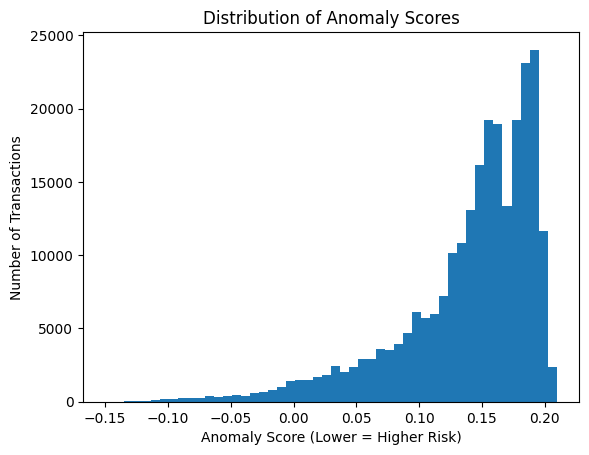

In [51]:
import matplotlib.pyplot as plt

plt.figure()
plt.hist(df_ml["anomaly_score"], bins=50)
plt.title("Distribution of Anomaly Scores")
plt.xlabel("Anomaly Score (Lower = Higher Risk)")
plt.ylabel("Number of Transactions")
plt.show()


# Transaction Amount vs Anomaly Score

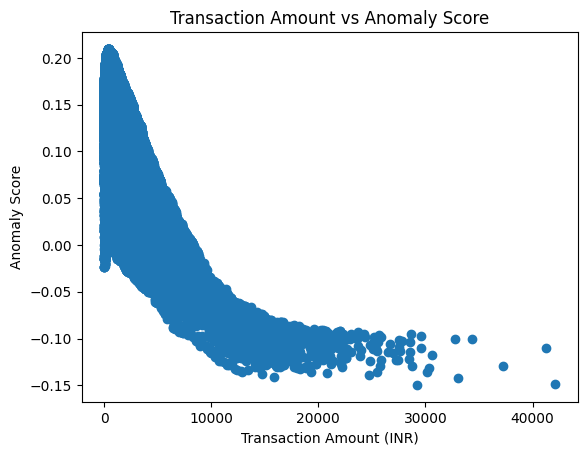

In [52]:
plt.figure()
plt.scatter(
    df_ml["amount_inr"],
    df_ml["anomaly_score"]
)
plt.title("Transaction Amount vs Anomaly Score")
plt.xlabel("Transaction Amount (INR)")
plt.ylabel("Anomaly Score")
plt.show()


In [53]:
# 8. Export for Power BI
# ----------------
df_ml.to_csv("upi_transactions_with_ml_output.csv", index=False)

print("✅ ML pipeline executed successfully. Output ready for Power BI.")

✅ ML pipeline executed successfully. Output ready for Power BI.
